# Data Cleaning & Pre-Processing

In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

In [3]:
data = pd.read_excel("/content/RuralAtlasData24.xlsx", sheet_name=None)

(N.B. Data read by uploading file locally to Google Colab Notebook)

In [4]:
people = data['People']
jobs = data['Jobs']
county_class = data['County Classifications']
income = data['Income']
veterans = data['Veterans']

Excel file contains multiple sheets, so 'data' is a dictionary of DataFrames

The code above extracts each individual DataFrame

In [5]:
people['State'].unique()

array(['US', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL',
       'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
       'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
       'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

Returns an array of the '53 states' to be looped over to extract information for states (Puerto Rico and D.C. are considered states + the national averages for each variable are also included under the state code 'US')

In [6]:
state_info_p = {}
state_info_j = {}
state_info_i = {}
state_info_v = {}

#People
for state in people['State'].unique():
  state_info_p[state]=people[people['State']==state].iloc[0]
state_info_p = pd.DataFrame(state_info_p).T

#Jobs
for state in people['State'].unique():
  state_info_j[state]=jobs[jobs['State']==state].iloc[0]
state_info_j = pd.DataFrame(state_info_j).T

#Income
for state in people['State'].unique():
  state_info_i[state]=income[income['State']==state].iloc[0]
state_info_i = pd.DataFrame(state_info_i).T

#Veterans
for state in people['State'].unique():
  state_info_v[state]=veterans[veterans['State']==state].iloc[0]
state_info_v = pd.DataFrame(state_info_v).T

df_states = pd.concat([state_info_p, state_info_j, state_info_i, state_info_v], axis=1, ignore_index=False)

Data on 'People', 'Jobs', 'Income' and 'Veterans' for each state (state averages) are stored in df_states

We will make another data frame containing the information for each county, without the states:

In [7]:
for i in [people, jobs, county_class, income, veterans]:
  print(len(i))

3280
3280
3227
3280
3280


**County classifications does not have the collated data for each state (3280-53 = 3227)**

Remove rows with FIPS multiple of 1000 (since this is what identifies each state) - this requires making FIPS a *numeric* variable

We also must make FIPS the index of all columns to join the data:

In [8]:
#People
people['FIPS'] = people['FIPS'].astype(int)
people = people[people['FIPS']%1000 != 0]
people.set_index("FIPS", inplace=True)

#Jobs
jobs['FIPS'] = jobs['FIPS'].astype(int)
jobs = jobs[jobs['FIPS']%1000 != 0]
jobs.set_index("FIPS", inplace=True)

#County_Classification (must change from FIPStxt - FIPS):
county_class = county_class.rename(columns={"FIPStxt": "FIPS"})
county_class['FIPS'] = county_class['FIPS'].astype(int)
county_class.set_index("FIPS", inplace=True)

#Income
income['FIPS'] = income['FIPS'].astype(int)
income = income[income['FIPS']%1000 != 0]
income.set_index("FIPS", inplace=True)

#Veterans
veterans['FIPS'] = veterans['FIPS'].astype(int)
veterans = veterans[veterans['FIPS']%1000 != 0]
veterans.set_index("FIPS", inplace=True)

In [9]:
df_counties = pd.concat([people, jobs, county_class, income, veterans], axis=1, ignore_index=False)

The concatenated data for counties contains multiple instances of 'FIPS' and 'State' so these repetitions must be removed

The data for the states also has this issue. Additionally, 'FIPS' and 'County' are no longer needed and can be removed.

In [10]:
df_counties = df_counties.loc[:, ~df_counties.columns.duplicated(keep='first')]

columns_to_remove = [col for col in df_states.columns if 'FIPS' in col or 'County' in col]
df_states = df_states.drop(columns=columns_to_remove)

df_states = df_states.loc[:, ~df_states.columns.duplicated(keep='first')]

### Handling NaNs

In [11]:
df_states = df_states.replace({np.nan: pd.NA})
df_counties = df_counties.replace({np.nan: pd.NA})

<ipython-input-11-6ccb7eb35412>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_states = df_states.replace({np.nan: pd.NA})


NaN values are converted to NAs instead, for Tableau to consistently view these as null values. (Sometimes NaNs are interpreted as 0s when imported in Tableau)

Final checks for duplicate rows:

In [12]:
df_counties.duplicated().value_counts()

,count
False,3227


In [13]:
df_states.duplicated().value_counts()

,count
False,53


## Adding new features

In [14]:
# Northeast Region
northeast = [
    "ME", "NH", "VT", "MA", "RI", "CT",
    "NY", "NJ", "PA"
]

# Midwest Region
midwest = [
    "OH", "IN", "IL", "MI", "WI",
    "MN", "IA", "MO", "ND",
    "SD", "NE", "KS"
]

# South Region
south = [
    "DE", "MD", "DC", "VA", "WV",
    "NC", "SC", "GA", "FL",
    "KY", "TN", "AL", "MS",
    "AR", "LA", "OK", "TX"
]

# West Region
west = [
    "MT", "ID", "WY", "CO",
    "NM", "AZ", "UT", "NV",
    "WA", "OR", "CA", "AK", "HI"
]

df_states['Region'] = [' ']*53

for index, row in df_states.iterrows():
  if row['State'] in northeast:
    df_states.loc[index, 'Region'] = 'Northeast'
  elif row['State'] in midwest:
    df_states.loc[index, 'Region'] = 'Midwest'
  elif row['State'] in south:
    df_states.loc[index, 'Region'] = 'South'
  elif row['State'] in west:
    df_states.loc[index, 'Region'] = 'West'

for index, row in df_counties.iterrows():
  if row['State'] in northeast:
    df_counties.loc[index, 'Region'] = 'Northeast'
  elif row['State'] in midwest:
    df_counties.loc[index, 'Region'] = 'Midwest'
  elif row['State'] in south:
    df_counties.loc[index, 'Region'] = 'South'
  elif row['State'] in west:
    df_counties.loc[index, 'Region'] = 'West'

For Geographical analysis, we can classify the U.S. states as being in either the Northeast, Midwest, South, or West Region

In [15]:
df_states['AvgUnempRate'] = (df_states['UnempRate2017'] + df_states['UnempRate2018'] + df_states['UnempRate2019'] + df_states['UnempRate2020'] + df_states['UnempRate2021'])/5
df_counties['AvgUnempRate'] = (df_counties['UnempRate2017'] + df_counties['UnempRate2018'] + df_counties['UnempRate2019'] + df_counties['UnempRate2020'] + df_counties['UnempRate2021'])/5

Computing the 5-year unemployment rate for each county (to match with pctpovall)

We have decided to exclude D.C. and Puerto Rico (states and counties) as they are not official states + they contain several anomolous/null results for various features

In [16]:
df_counties = df_counties[df_counties['State']!= 'DC']
df_counties = df_counties[df_counties['State']!= 'PR']
df_counties.shape

(3148, 258)

In [17]:
df_states = df_states[df_states['State']!= 'DC']
df_states = df_states[df_states['State']!= 'PR']

In [18]:
df_states.shape

(51, 215)

In [19]:
national_averages = df_states.iloc[0]
df_states = df_states.drop(df_states.index[0])

The US Averages for each feature must be removed from df_states and stored separately for comparison in analyses:

## Exporting to CSV

In [20]:
df_states.to_csv("States.csv")

In [21]:
df_counties.to_csv("Counties.csv")

# Preparing for Visualizations

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

df_states = pd.read_csv("States.csv")
df_counties = pd.read_csv("Counties.csv")

# Visualizations

## Correlations

In [23]:
correlations = df_counties.corr(numeric_only=True, method='pearson')['PCTPOVALL']
print(correlations[correlations.abs()>0.4].sort_values(ascending=False))

PCTPOVALL                           1.000000
PCTPOV017                           0.938169
Poverty_Rate_ACS                    0.890321
PctNonVetsPoor                      0.852749
Poverty_Rate_0_17_ACS               0.806029
Deep_Pov_All                        0.760491
Deep_Pov_Children                   0.704051
Hipov                               0.692846
PersistentChildPoverty2004          0.681427
PersistentChildPoverty_1980_2011    0.681066
PersistentPoverty2000               0.654068
Perpov_1980_0711                    0.648432
Ed1LessThanHSPct                    0.637551
FemaleHHPct                         0.627696
Low_Employment_2015_update          0.602874
UnempRate2015                       0.598704
UnempRate2016                       0.589491
PctNonVetsDisabilty                 0.569856
LowEducation2000                    0.561735
UnempRate2017                       0.561044
UnempRate2014                       0.558153
UnempRate2018                       0.532408
UnempRate2

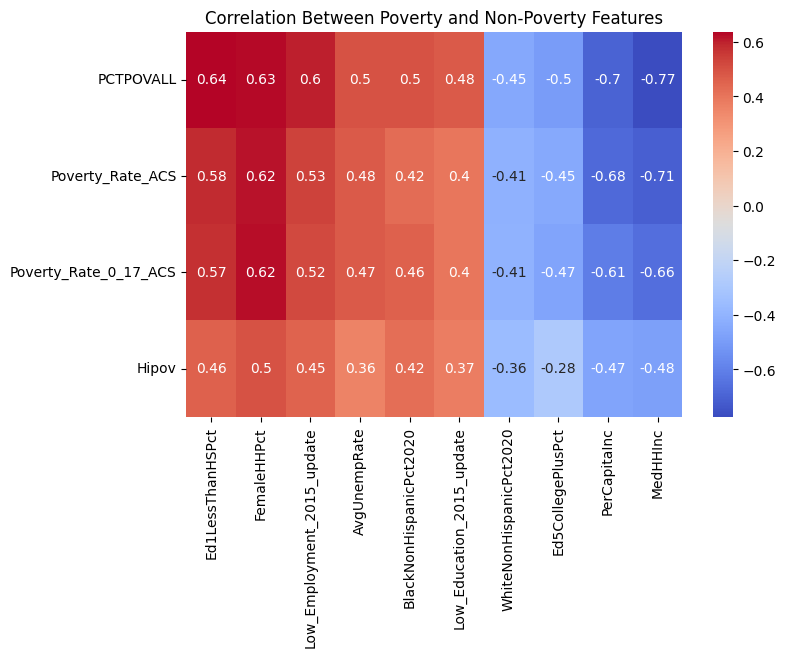

In [24]:
poverty = ['PCTPOVALL', 'Poverty_Rate_ACS', 'Poverty_Rate_0_17_ACS', 'Hipov']
non_poverty = ['Ed1LessThanHSPct', 'FemaleHHPct', 'Low_Employment_2015_update', 'AvgUnempRate', 'BlackNonHispanicPct2020', 'Low_Education_2015_update', 'WhiteNonHispanicPct2020', 'Ed5CollegePlusPct', 'PerCapitaInc', 'MedHHInc']

# Calculate the correlation matrix using .corr() instead of .corrwith()
correlation_matrix = df_counties[poverty + non_poverty].corr(numeric_only=True, method='pearson').loc[poverty, non_poverty]


# Visualize the matrix using a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=non_poverty, yticklabels=poverty)
plt.title("Correlation Between Poverty and Non-Poverty Features")
plt.show()

In [25]:
variables_of_interest = ['PCTPOVALL', 'Ed1LessThanHSPct', 'FemaleHHPct', 'AvgUnempRate', 'BlackNonHispanicPct2020', 'WhiteNonHispanicPct2020', 'Ed5CollegePlusPct', 'PerCapitaInc', 'MedHHInc']
for var in variables_of_interest:
  print(var, national_averages[var])

PCTPOVALL 12.8
Ed1LessThanHSPct 11.1259596764
FemaleHHPct 12.316068724
AvgUnempRate 5.1
BlackNonHispanicPct2020 12.050211084935194
WhiteNonHispanicPct2020 57.836193345068686
Ed5CollegePlusPct 33.6700217036
PerCapitaInc 37638.0
MedHHInc 69717.0


## Data Summarization

In [26]:
df_counties['PCTPOVALL'].describe()

,PCTPOVALL
count,3141.000000
mean,14.609169
std,5.663881
min,2.900000
25%,10.600000
50%,13.600000
75%,17.600000
max,43.900000


17.6 + 1.5(7) = 28.1

A poverty rate above 28.1% is considered an outlier

<Axes: xlabel='Region', ylabel='PCTPOVALL'>

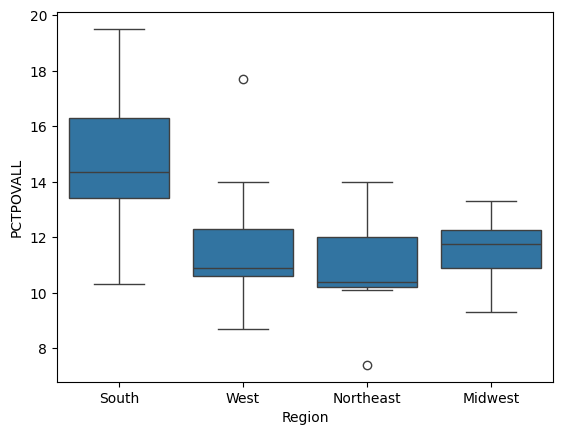

In [27]:
sns.boxplot(x='Region', y='PCTPOVALL', data=df_states)

Southern states have a much higher poverty rate than states in other regions

<Axes: xlabel='MedHHInc', ylabel='Count'>

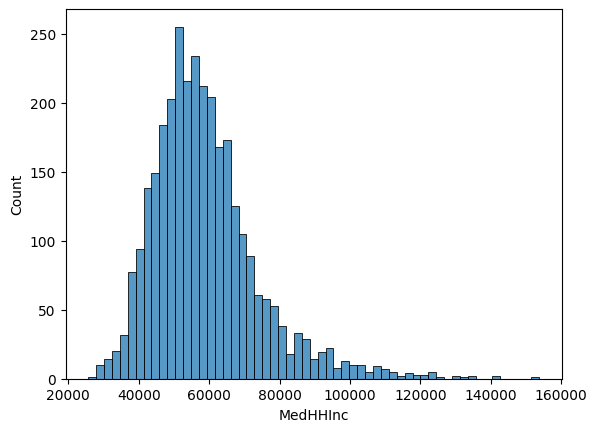

In [28]:
sns.histplot(x='MedHHInc', data=df_counties)

In [29]:
national_averages['MedHHInc']

69717.0

## Factors affecting poverty

### Unemployment Rate

<Axes: xlabel='AvgUnempRate', ylabel='PCTPOVALL'>

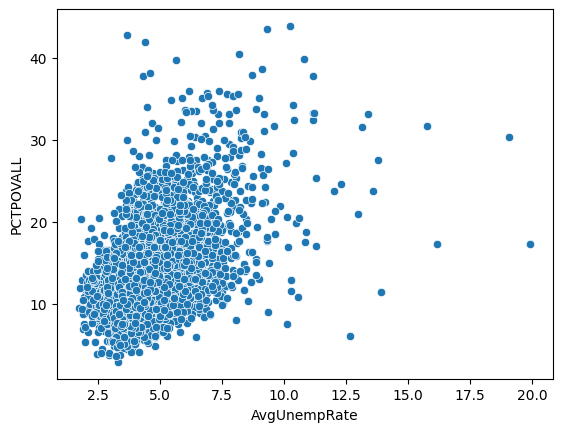

In [30]:
sns.scatterplot(x='AvgUnempRate', y='PCTPOVALL', data=df_counties)

<Axes: xlabel='Region', ylabel='AvgUnempRate'>

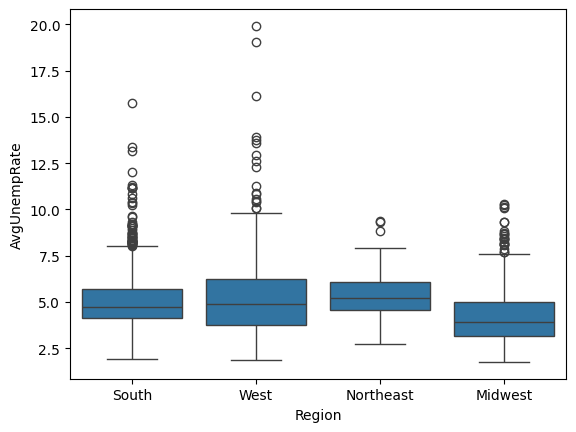

In [31]:
sns.boxplot(x='Region', y='AvgUnempRate', data=df_counties)

While unemployment appears to have an effect on poverty, all regions suffer from unemployment to a similar degree

### Percentage of Black Population

In [32]:
national_averages['BlackNonHispanicPct2020']

12.050211084935194

In [33]:
df_counties['BlackNonHispanicPct2020'].describe()

,BlackNonHispanicPct2020
count,3142.000000
mean,8.571663
std,14.017293
min,0.000000
25%,0.495746
50%,1.983001
75%,9.650514
max,87.126437


We have chosen to observe the top half counties with the largest black populations (>1.83%, as per the median value) in our analysis to determine whether or not a relatively large black population has an effect on poverty

### Percentage of White people of the whole population

In [34]:
national_averages['WhiteNonHispanicPct2020']

57.836193345068686

In [35]:
df_counties['WhiteNonHispanicPct2020'].describe()

,WhiteNonHispanicPct2020
count,3142.000000
mean,74.162432
std,19.796706
min,1.776396
25%,62.589658
50%,80.728143
75%,90.343988
max,97.404829


We have chosen to observe the bottom half of counties with the smallest white populations (<.80.7%, as per the median value) in our analysis to determine whether or not a small white population has an effect on poverty

### Percentage of Hispanic Population

In [36]:
df_counties['HispanicPct2020'].describe()

,HispanicPct2020
count,3142.000000
mean,9.788272
std,13.685627
min,0.167304
25%,2.371242
50%,4.609790
75%,10.443061
max,97.683556


Filter to show above the median (>4.6%)

In [39]:
df_counties[df_counties['HispanicPct2020']>4.6].corr(numeric_only=True, method='pearson')['PCTPOVALL']['HispanicPct2020']

0.27620916960272934

Weak correlation

### Low Education

<Axes: xlabel='Low_Education_2015_update', ylabel='PCTPOVALL'>

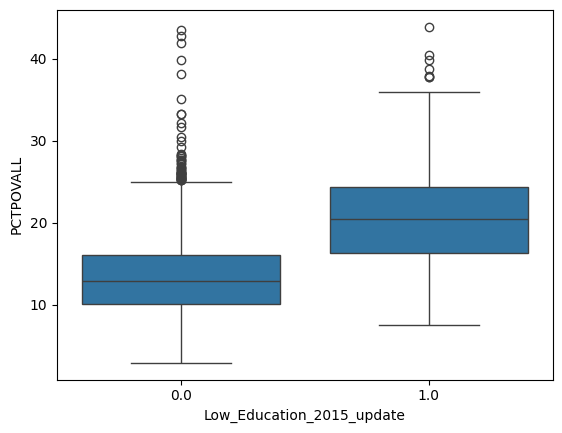

In [37]:
sns.boxplot(x='Low_Education_2015_update', y='PCTPOVALL', data=df_counties)

It appears that counties classified as being 'low education counties' (taking the value 1) suffer from poverty to a greater degree